In [16]:
import ssl
print(ssl.OPENSSL_VERSION)

OpenSSL 1.1.1s  1 Nov 2022


In [17]:
!pip install --upgrade pip

Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available.")) - skipping
Could not fetch URL https://pypi.org/simple/pip/: There was a problem confirming the ssl certificate: HTTPSConnectionPool(host='pypi.org', port=443): Max retries exceeded with url: /simple/pip/ (Caused by SSLError("Can't connect to HTTPS URL because the SSL module is not available.")) - skipping


In [18]:
pip install stardist


[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [19]:
pip install tensorflow

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip available: 22.3.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [45]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
#matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt


from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist.matching import matching, matching_dataset
from stardist.models import Config2D, StarDist2D, StarDistData2D

In [46]:
from stardist.models import StarDist2D

# prints a list of available models
StarDist2D.from_pretrained()

# creates a pretrained model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

There are 4 registered models for 'StarDist2D':

Name                  Alias(es)
────                  ─────────
'2D_versatile_fluo'   'Versatile (fluorescent nuclei)'
'2D_versatile_he'     'Versatile (H&E nuclei)'
'2D_paper_dsb2018'    'DSB 2018 (from StarDist 2D paper)'
'2D_demo'             None
Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


In [56]:
from stardist.data import test_image_nuclei_2d
from stardist.plot import render_label
from csbdeep.utils import normalize
import matplotlib.pyplot as plt

img = sorted(glob('image.tif'))
img= list(map(imread,img))
img_lab= sorted(glob('image_labeled.tif'))
img_lab= list(map(imread,img_lab))
print(len(img))

1


In [57]:
#Random color map labels
np.random.seed(42)
lbl_cmap = random_label_cmap()

#Read input image and corresponding mask names
X = sorted(glob('image.tif'))
Y = sorted(glob('image_labeled.tif'))

import numpy as np
def slice_numpy_array(image_array):
    # Get the shape of the original array
    height, width = image_array.shape

    # Ensure that both dimensions are divisible by 16
    new_height = height - (height % 16)
    new_width = width - (width % 16)
    image_array = image_array[:new_height, :new_width]

    # Calculate the dimensions of each slice
    slice_height = new_height // 3
    slice_width = new_width // 3

    # List to store the sliced arrays
    sliced_arrays = []

    # Loop through each row and column to slice the array
    for row in range(3):
        for col in range(3):
            upper = row * slice_height
            left = col * slice_width
            lower = upper + slice_height
            right = left + slice_width

            # Ensure that both dimensions of the subarray are divisible by 16
            subarray = image_array[upper:lower, left:right]
            subarray_height, subarray_width = subarray.shape
            subarray = subarray[:subarray_height - (subarray_height % 16), :subarray_width - (subarray_width % 16)]

            # Append the subarray to the list
            sliced_arrays.append(subarray)

            # Do something with the subarray (in this case, just displaying its shape)
            print(f"Subarray at row {row + 1}, column {col + 1}: {subarray.shape}")

    return sliced_arrays

X = list(map(imread,X))
Y = list(map(imread,Y))
img = slice_numpy_array(X[0])
img_lab = slice_numpy_array(Y[0])

Subarray at row 1, column 1: (176, 256)
Subarray at row 1, column 2: (176, 256)
Subarray at row 1, column 3: (176, 256)
Subarray at row 2, column 1: (176, 256)
Subarray at row 2, column 2: (176, 256)
Subarray at row 2, column 3: (176, 256)
Subarray at row 3, column 1: (176, 256)
Subarray at row 3, column 2: (176, 256)
Subarray at row 3, column 3: (176, 256)
Subarray at row 1, column 1: (176, 256)
Subarray at row 1, column 2: (176, 256)
Subarray at row 1, column 3: (176, 256)
Subarray at row 2, column 1: (176, 256)
Subarray at row 2, column 2: (176, 256)
Subarray at row 2, column 3: (176, 256)
Subarray at row 3, column 1: (176, 256)
Subarray at row 3, column 2: (176, 256)
Subarray at row 3, column 3: (176, 256)


In [58]:
#Define a few augmentation methods
def random_fliprot(img, mask):
    assert img.ndim >= mask.ndim
    axes = tuple(range(mask.ndim))
    perm = tuple(np.random.permutation(axes))
    img = img.transpose(perm + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(perm)
    for ax in axes:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img


def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    x, y = random_fliprot(x, y)
    x = random_intensity_change(x)
    # add some gaussian noise
    sig = 0.02*np.random.uniform(0,1)
    x = x + sig*np.random.normal(0,1,x.shape)
    return x, y

100%|██████████| 9/9 [00:01<00:00,  4.66it/s]


DatasetMatching(criterion='iou', thresh=0.3, fp=327, tp=209, fn=40, precision=0.38992537313432835, recall=0.8393574297188755, accuracy=0.3628472222222222, f1=0.532484076433121, n_true=249, n_pred=536, mean_true_score=0.47080008571885196, mean_matched_score=0.5609053652822686, panoptic_quality=0.2986731753987112, by_image=False)

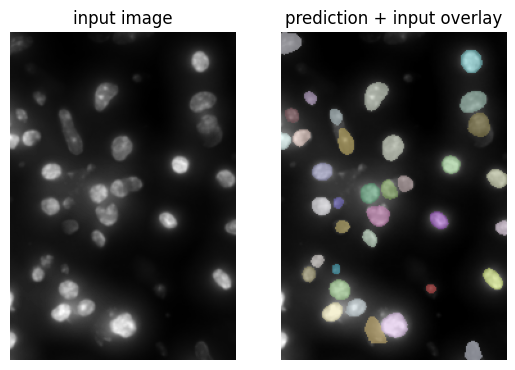

In [59]:
img[0], img_lab[0] = augmenter(img[0], img_lab[0])
labels, _ = model.predict_instances(normalize(img[0])) #or for loop if many images


plt.subplot(1,2,1)
plt.imshow(img[0], cmap="gray")
plt.axis("off")
plt.title("input image")

plt.subplot(1,2,2)
plt.imshow(render_label(labels, img=img[0]))
plt.axis("off")
plt.title("prediction + input overlay")


taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_lab[0], labels, thresh=t, show_progress=False) for t in tqdm(taus)]
stats[taus.index(0.3)]

Running pre-trained model of stardist with our image and its mask 

In [51]:

print("OK")
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(img_lab[0],labels, thresh=t, show_progress=False) for t in tqdm(taus)]  #y_val = img_lab[0]? on compare GT avec predicted image with the pretrained model ?
stats[taus.index(0.3)]

OK


100%|██████████| 9/9 [00:04<00:00,  2.23it/s]


DatasetMatching(criterion='iou', thresh=0.3, fp=7043, tp=6, fn=522, precision=0.0008511845651865513, recall=0.011363636363636364, accuracy=0.0007924976885484084, f1=0.0015837402665962782, n_true=528, n_pred=7049, mean_true_score=0.004461793172540087, mean_matched_score=0.39263779918352765, panoptic_quality=0.000621836292754696, by_image=False)

In [ ]:
import numpy as np
from sklearn.metrics import f1_score

def compute_f1_score(y_true, y_pred):
    if y_true.ndim == 1 and y_pred.ndim == 1:
        # Binary classification
        return f1_score(y_true, y_pred)
    else:
        # Multilabel-indicator or multiclass-multioutput
        if y_true.shape[1] == 1 or y_pred.shape[1] == 1:
            # Multilabel-indicator
            y_true = y_true.ravel()
            y_pred = y_pred.ravel()
        else:
            # Multiclass-multioutput
            y_true = np.argmax(y_true, axis=1)
            y_pred = np.argmax(y_pred, axis=1)
        
        return f1_score(y_true, y_pred, average='macro')

# for our example

image2_cv = np.array(image2)
f1 = compute_f1_score(image2_cv, labels)
print("F1 value between the GT and the pre-trained model of Stardist", f1)

F1 value between the GT and the pre-trained model of Stardist 0.008039060869249548
